# Import modules

In [1]:
# imports
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
import matplotlib.pyplot as plt
from zipfile import ZipFile
from scipy import sparse
import seaborn as sns
import pandas as pd
import numpy as np
import os



## Preprocessing

### Unzip data

In [2]:
# Extract data
def preDot(txt):
    return txt.rsplit('.', 1)[0]

np.random.seed(73)
pd.options.mode.chained_assignment = None
path = "../data/kaggle/" # Path of dataset 
dataDict = {}

for dirname, _ , filenames in os.walk(path) :
    #print(filenames)
    for filename in filenames:
        if filename.endswith('.zip'):
            print(os.path.join(dirname, filename))
            with ZipFile(os.path.join(dirname, filename), 'r') as zipf:
                unzipped_fn = preDot(filename)
                with zipf.open(unzipped_fn) as f:
                    dataDict[preDot(unzipped_fn)] = pd.read_csv(f)

train_orders = dataDict['orders'][dataDict['orders']['eval_set'] == 'train'].drop('eval_set', axis=1)
prior_orders = dataDict['orders'][dataDict['orders']['eval_set'] == 'prior'].drop('eval_set', axis=1)
test_orders = dataDict['orders'][dataDict['orders']['eval_set'] == 'test'].drop('eval_set', axis=1)

../data/kaggle/aisles.csv.zip
../data/kaggle/departments.csv.zip
../data/kaggle/orders.csv.zip
../data/kaggle/order_products__prior.csv.zip
../data/kaggle/order_products__train.csv.zip
../data/kaggle/products.csv.zip
../data/kaggle/sample_submission.csv.zip


### Exploration


In [ ]:
dataDict.keys()

dict_keys(['aisles', 'departments', 'orders', 'order_products__prior', 'order_products__train', 'products', 'sample_submission'])

In [4]:
def display_head(df):
    print(df.head(),'\n')


In [5]:
for file in dataDict.keys():
    print(file,'\n')
    display_head(dataDict[file])

aisles 

   aisle_id                       aisle
0         1       prepared soups salads
1         2           specialty cheeses
2         3         energy granola bars
3         4               instant foods
4         5  marinades meat preparation 

departments 

   department_id department
0              1     frozen
1              2      other
2              3     bakery
3              4    produce
4              5    alcohol 

orders 

   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day   
0   2539329        1    prior             1          2                  8  \
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2        

### Transactional Table Preparation

In [14]:
small_train_data = dataDict['order_products__train'][['order_id', 'product_id']]

In [15]:
small_train_data.shape

(1384617, 2)

In [16]:
print(f' Il y\'a {len(small_train_data.order_id.unique())} transactions et {len(small_train_data.product_id.unique())} produits')

 Il y'a 131209 transactions et 39123 produits


In [26]:
small_train_data.dtypes

order_id      int64
product_id    int64
dtype: object

In [66]:
# Table of articles
products = dataDict["products"]

In [28]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [29]:
products.nunique()

product_id       49688
product_name     49688
aisle_id           134
department_id       21
dtype: int64

In [30]:
products['product_name']

0                               Chocolate Sandwich Cookies
1                                         All-Seasons Salt
2                     Robust Golden Unsweetened Oolong Tea
3        Smart Ones Classic Favorites Mini Rigatoni Wit...
4                                Green Chile Anytime Sauce
                               ...                        
49683            Vodka, Triple Distilled, Twist of Vanilla
49684                   En Croute Roast Hazelnut Cranberry
49685                                     Artisan Baguette
49686           Smartblend Healthy Metabolism Dry Cat Food
49687                               Fresh Foaming Cleanser
Name: product_name, Length: 49688, dtype: object

In [31]:
# La table de transaction ne peut pas tenir dans la memoire
# Split en 3 parties
small_train_data_split = (small_train_data[:461543],
                            small_train_data[461543:461543*2-1],
                            small_train_data[461543*2-1:])

In [32]:
small_train_data_split[0].size

923086

In [33]:
small_train_data_split[1].size

923084

In [34]:
small_train_data_split[2].size

923064

In [35]:
# Traitement des valeurs manquantes

pivots = []
for df in small_train_data_split :
    pvt = ~(df.pivot(index='order_id', columns='product_id', values='product_id').isna())
    pivots.append(pvt.astype(pd.SparseDtype(bool)))
del pvt

product_cols = sorted(small_train_data.product_id.unique())

In [36]:
# Condenser les produits pour chaque transaction
for i in range(len(pivots)):
    pivots[i] = pivots[i].reindex(columns=product_cols, fill_value=False).astype(pd.SparseDtype(bool))
    pivots[i] = sparse.csr_matrix(pivots[i])

pivots = sparse.vstack(pivots)

truth_table=pd.DataFrame(pivots.todense(), index=small_train_data.order_id.unique(),
                        columns=product_cols)

In [37]:
truth_table.shape

(131209, 39123)

In [38]:
truth_table.head()

,1,2,3,4,5,7,8,9,10,11,...,49677,49678,49679,49680,49681,49682,49683,49686,49687,49688
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
36,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
38,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
96,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
98,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Algorithmes

### Regles d'associations

Voyons le probleme sous l'angle de correlations entre les items en fonction du comportement d'achat.

On cherche donc à savoir quel produit est succeptible d'être acheter en fonction de la composition du panier d'achat.

Formellement ? quelles combinaisons de produits sont fréquemment achetées ensemble ?

#### Apriori

1. Generer les itemset frequents
2. Former les règles d'associations

Generation des itemset frequents

In [39]:
# Seuil de support
min_sup = [0.001*i for i in range(4,100,2) ]

In [43]:
import timeit
apriori_start_time = timeit.default_timer()
freq_itemsets_ap = []
for i in min_sup:
    tmp_f = apriori(truth_table, min_support=i, use_colnames=True)
    freq_itemsets_ap.append(tmp_f)
apriori_time = timeit.default_timer() - apriori_start_time

In [44]:
print(f"Temps Apriori pour generer: {apriori_time:.2f} S")

Temps Apriori pour generer: 1208.07 S


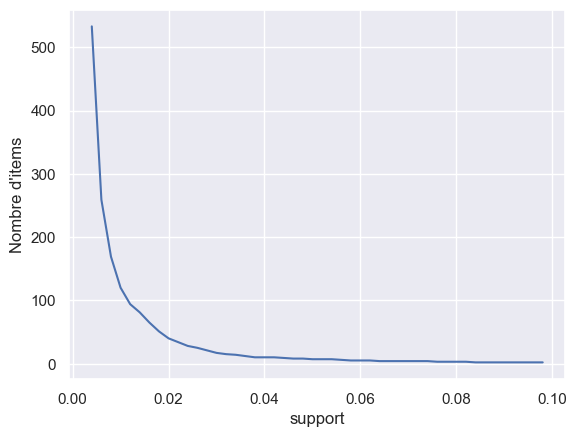

In [45]:
# Plot frequent itemset with minsup
sns.set()
y_ap = [i.shape[0] for i in freq_itemsets_ap]
X_ap = min_sup
plt.plot(X_ap,y_ap)
plt.xlabel('support')
plt.ylabel('Nombre d\'items')
plt.show()


In [46]:
freq_itemsets_ap[2].head()

,support,itemsets
0,0.011485,(196)
1,0.009260,(260)
2,0.009733,(432)
3,0.008887,(2295)
4,0.009893,(3957)


In [47]:
freq_itemsets_ap[2].shape

(169, 2)

In [48]:
# Choix apriori avec min sup = 0.8%
freq_itemsets_ap_1 =  freq_itemsets_ap[2]
freq_itemsets_ap_1['length'] = freq_itemsets_ap_1['itemsets'].apply(lambda x:len(x))
freq_itemsets_ap_1

,support,itemsets,length
0,0.011485,(196),1
1,0.009260,(260),1
2,0.009733,(432),1
3,0.008887,(2295),1
4,0.009893,(3957),1
...,...,...,...
164,0.009382,"(45066, 24852)",2
165,0.016447,"(47626, 24852)",2
166,0.016889,"(24852, 47766)",2
167,0.012156,"(26209, 47626)",2


2. Generer des regles d'associations

In [49]:
min_sup_c = 0.001

In [50]:
rules_aprioi = association_rules(freq_itemsets_ap_1, metric='support', min_threshold=min_sup_c)

In [51]:
rules_aprioi.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(24852),(4605),0.142719,0.028672,0.008163,0.057193,1.994754,0.004071,1.030252,0.581705
1,(4605),(24852),0.028672,0.142719,0.008163,0.284689,1.994754,0.004071,1.198473,0.513405
2,(4920),(24852),0.030935,0.142719,0.008856,0.286277,2.005883,0.004441,1.201141,0.517475
3,(24852),(4920),0.142719,0.030935,0.008856,0.062053,2.005883,0.004441,1.033176,0.584950
4,(13176),(5876),0.117980,0.026713,0.008132,0.068928,2.580293,0.004980,1.045340,0.694369


In [52]:
rules_aprioi.shape

(60, 10)

In [53]:
# Les 10 règles qui se produisent le plus souvent
rules_aprioi.sort_values(by='confidence',ascending=False)[:10]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
48,(28204),(24852),0.024823,0.142719,0.009222,0.371508,2.603072,0.005679,1.364028,0.631515
50,(45066),(24852),0.027064,0.142719,0.009382,0.346663,2.428991,0.005519,1.312157,0.604671
19,(47209),(13176),0.055583,0.117980,0.018444,0.331825,2.812560,0.011886,1.320044,0.682381
13,(27966),(13176),0.042268,0.117980,0.013566,0.320952,2.720400,0.008579,1.298907,0.660318
5,(5876),(13176),0.026713,0.117980,0.008132,0.304422,2.580293,0.004980,1.268040,0.629257
31,(27966),(21137),0.042268,0.083028,0.012728,0.301118,3.626710,0.009218,1.312056,0.756233
25,(16797),(24852),0.049494,0.142719,0.014847,0.299969,2.101819,0.007783,1.224633,0.551518
55,(47766),(24852),0.056467,0.142719,0.016889,0.299096,2.095698,0.008830,1.223107,0.554122
2,(4920),(24852),0.030935,0.142719,0.008856,0.286277,2.005883,0.004441,1.201141,0.517475
1,(4605),(24852),0.028672,0.142719,0.008163,0.284689,1.994754,0.004071,1.198473,0.513405


Predictions

In [54]:
rules_ante_cons = rules_aprioi[['antecedents', 'consequents']]

In [55]:
baskets = small_train_data.groupby('order_id')['product_id'].apply(frozenset)

In [56]:
baskets

order_id
1          (11109, 10246, 47209, 43633, 49683, 22035, 493...
36         (34497, 46979, 48679, 19660, 43086, 49235, 396...
38         (42625, 23622, 11913, 28842, 4461, 39693, 1815...
96         (40706, 24489, 25610, 39275, 30391, 20574, 27966)
98         (46720, 24964, 4357, 43654, 18441, 36364, 3406...
                                 ...                        
3421049           (40800, 34243, 17706, 33424, 26800, 17299)
3421056                    (21709, 12432, 5750, 16475, 9340)
3421058    (34466, 6244, 6858, 32650, 30316, 15629, 35578...
3421063                         (14233, 49235, 35548, 13565)
3421070                                 (16953, 4724, 35951)
Name: product_id, Length: 131209, dtype: object

In [57]:
baskets.name = 'basket'

In [58]:
recommendations = train_orders.join(baskets, on='order_id')
recommendations['recommendations'] = [frozenset() for _ in range(len(recommendations))]

In [59]:
for idx, antecedent in enumerate(rules_ante_cons["antecedents"]):
    lookup = antecedent <= recommendations.basket, "recommendations"
    recommendations.loc[lookup] = recommendations.loc[lookup].apply(
        frozenset.union,
        args=(rules_ante_cons.loc[idx, "consequents"],)
    )

In [60]:
recommendations.loc[:, "recommendations"] = recommendations.recommendations - recommendations.basket

In [61]:
# non-empty recommendations
non_empty_recs = recommendations[recommendations.recommendations.apply(bool)]
print("1 out of approx.", round(1/(len(non_empty_recs) / len(recommendations))), "transactions will result in a recommendation being suggested to a customer.")
# mapping codes to product names
def map_products(codes):
    if isinstance(codes, pd.Series):
        return codes.apply(map_products)
    return frozenset(map(products.get, codes))

products = dataDict["products"]
products = products.set_index("product_id")["product_name"].to_dict()
non_empty_recs.loc[:, ["basket", "recommendations"]] = non_empty_recs[["basket", "recommendations"]].apply(map_products)
print(non_empty_recs)

1 out of approx. 2 transactions will result in a recommendation being suggested to a customer.
         order_id  user_id  order_number  order_dow  order_hour_of_day   
10        1187899        1            11          4                  8  \
25        1492625        2            15          1                 11   
74         525192        7            21          2                 11   
78         880375        8             4          1                 14   
200       2180313       17            41          3                 10   
...           ...      ...           ...        ...                ...   
3420786   3383615   206196             5          0                 15   
3420862    943915   206200            24          6                 19   
3420924   2371631   206203             6          4                 19   
3420933   1716008   206205             4          1                 16   
3421082    272231   206209            14          6                 14   

         days_si

In [76]:
# Predire une recommandation en fonction d'un produit
def arl_recommender(rules_df, product):
    sorted_rules = rules_df.sort_values("lift", ascending=False)
    recommendation_list = []
    for i, antecedent in enumerate(sorted_rules["antecedents"]):
        if product in antecedent:
            recommendation_list.append(list(sorted_rules.iloc[i]["consequents"])[0])
            
    return recommendation_list
     

In [78]:
products_ = dataDict["products"]

In [77]:

arl_recommender(rules_aprioi, 28204)

[24852]

In [80]:
products_.loc[products_["product_id"] == 24852, "product_name"]

24851    Banana
Name: product_name, dtype: object

#### FPGrowth

Une amelioration d'Apriori pour gain en temps et mémoire
1. Test de memoire
2. Test temps d'execution

1. Test de memoire

In [81]:
tmp_g = fpgrowth(truth_table, min_support=0.0001, use_colnames=True)

In [82]:
tmp_g.shape

(136394, 2)

In [ ]:
#tmp_a = apriori(truth_table, min_support=0.0001, use_colnames=True)

MemoryError: Unable to allocate 15.9 TiB for an array with shape (66741681, 2, 131209) and data type bool

Frequent itemset

2. temps d'execution

In [83]:
fp_time_start = timeit.default_timer()
freq_itemsets_fpg = []
for i in min_sup:
    tmp_f = fpgrowth(truth_table, min_support=i, use_colnames=True)
    freq_itemsets_fpg.append(tmp_f)

fp_time = timeit.default_timer() - fp_time_start

In [84]:
print(f"Temps FPGrowth : {fp_time:.2f} s")

Temps FPGrowth : 515.68 s


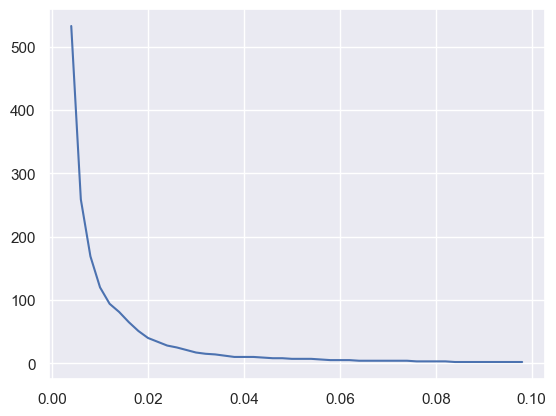

In [85]:
# Plot frequent itemset with minsup
sns.set()
y_fpg = [i.shape[0] for i in freq_itemsets_fpg]
X_fpg = min_sup
plt.plot(X_fpg,y_fpg)
plt.show()


In [86]:
freq_itemsets_fpg1 = freq_itemsets_fpg[2]
freq_itemsets_fpg1.head()

,support,itemsets
0,0.117980,(13176)
1,0.055583,(47209)
2,0.018391,(49683)
3,0.015190,(22035)
4,0.008094,(10246)


In [87]:
freq_itemsets_fpg1.shape

(169, 2)

In [88]:
freq_itemsets_fpg1['length'] = freq_itemsets_fpg1['itemsets'].apply(lambda x:len(x))
freq_itemsets_fpg1

,support,itemsets,length
0,0.117980,(13176),1
1,0.055583,(47209),1
2,0.018391,(49683),1
3,0.015190,(22035),1
4,0.008094,(10246),1
...,...,...,...
164,0.010281,"(47626, 47766)",2
165,0.008155,"(13176, 47766)",2
166,0.008856,"(4920, 24852)",2
167,0.009222,"(28204, 24852)",2


Generer des règles

In [89]:
rules_fpg = association_rules(freq_itemsets_fpg1, metric='support', min_threshold=min_sup_c)

In [90]:
# Les 10 regles qui se produisent le plus souvent
rules_fpg.sort_values(by='confidence', ascending=False)[:10]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
56,(28204),(24852),0.024823,0.142719,0.009222,0.371508,2.603072,0.005679,1.364028,0.631515
40,(45066),(24852),0.027064,0.142719,0.009382,0.346663,2.428991,0.005519,1.312157,0.604671
1,(47209),(13176),0.055583,0.117980,0.018444,0.331825,2.812560,0.011886,1.320044,0.682381
7,(27966),(13176),0.042268,0.117980,0.013566,0.320952,2.720400,0.008579,1.298907,0.660318
17,(5876),(13176),0.026713,0.117980,0.008132,0.304422,2.580293,0.004980,1.268040,0.629257
9,(27966),(21137),0.042268,0.083028,0.012728,0.301118,3.626710,0.009218,1.312056,0.756233
23,(16797),(24852),0.049494,0.142719,0.014847,0.299969,2.101819,0.007783,1.224633,0.551518
47,(47766),(24852),0.056467,0.142719,0.016889,0.299096,2.095698,0.008830,1.223107,0.554122
54,(4920),(24852),0.030935,0.142719,0.008856,0.286277,2.005883,0.004441,1.201141,0.517475
59,(4605),(24852),0.028672,0.142719,0.008163,0.284689,1.994754,0.004071,1.198473,0.513405


Test avec support plus faible

In [91]:
tmp_g['length'] = tmp_g['itemsets'].apply(lambda x:len(x))
tmp_g

,support,itemsets,length
0,0.117980,(13176),1
1,0.055583,(47209),1
2,0.018391,(49683),1
3,0.015190,(22035),1
4,0.008094,(10246),1
...,...,...,...
136389,0.000191,"(17630, 895)",2
136390,0.000122,"(24852, 895)",2
136391,0.000122,"(18987, 44870)",2
136392,0.000107,"(42345, 42085)",2


In [92]:
rules_fpg_test_m = association_rules(tmp_g, metric='support', min_threshold=min_sup_c)

In [93]:
rules_fpg_test_m.shape

(6846, 10)

In [94]:
rules_fpg.shape

(60, 10)

In [97]:
rules_fpg_test_m.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(13176),(47209),0.117980,0.055583,0.018444,0.156331,2.812560,0.011886,1.119416,0.730654
1,(47209),(13176),0.055583,0.117980,0.018444,0.331825,2.812560,0.011886,1.320044,0.682381
2,(47209),(21137),0.055583,0.083028,0.011729,0.211024,2.541609,0.007114,1.162231,0.642246
3,(21137),(47209),0.083028,0.055583,0.011729,0.141270,2.541609,0.007114,1.099784,0.661469
4,(47209),(21903),0.055583,0.074568,0.009542,0.171671,2.302212,0.005397,1.117228,0.598925


In [98]:
# Les 10 regles qui se produisent souvent
rules_fpg_test_m.sort_values(by='confidence', ascending=False)[:10]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
619,"(47209, 21137, 27966)",(13176),0.002904,0.117980,0.001738,0.598425,5.072272,0.001395,2.196403,0.805188
959,"(47209, 21137, 30391)",(13176),0.001951,0.117980,0.001067,0.546875,4.635331,0.000837,1.946528,0.785799
6560,"(39928, 47209)",(13176),0.002652,0.117980,0.001448,0.545977,4.627719,0.001135,1.942678,0.785996
6252,"(27966, 8174)",(13176),0.002126,0.117980,0.001151,0.541219,4.587387,0.000900,1.922529,0.783677
6448,"(4605, 16797)",(24852),0.002134,0.142719,0.001143,0.535714,3.753633,0.000839,1.846452,0.735160
178,"(47209, 22035)",(13176),0.002180,0.117980,0.001158,0.531469,4.504745,0.000901,1.882521,0.779711
6246,"(47209, 8174)",(13176),0.002828,0.117980,0.001494,0.528302,4.477905,0.001160,1.869883,0.778884
606,"(47209, 27966)",(13176),0.007766,0.117980,0.004047,0.521099,4.416854,0.003131,1.841760,0.779649
5818,"(47209, 22825)",(13176),0.002683,0.117980,0.001387,0.517045,4.382495,0.001071,1.826301,0.773896
1722,"(47209, 35951)",(13176),0.002431,0.117980,0.001250,0.514107,4.357585,0.000963,1.815255,0.772393


In [100]:
# Predictions
arl_recommender(rules_fpg_test_m, 3599)

[21137, 24852]

## Approche heuristique

## SARL : scalable association rule learning

## Approche ensembliste : XGBoost (eXtreme Gradient Boosting)

### Definition du problème 

Supposons que nous ne voulons pas faire une recommandation sur la base des transactions de multiples utilisateur, mais cible specifiquement un utilisateur et lui recommander un produit sur la base de ces precedentes commandes.

Par conséquent, nous voulons prédire quels produits achetés précédemment (commandes antérieures) figureront dans la prochaine commande d'un utilisateur.

## Deep Learning using clustering